In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm

In [2]:
train_dir = "/media/ActiveTraining/Datasets/COCO/train/"
val_dir = "/media/ActiveTraining/Datasets/COCO/val/"

train_images = glob(os.path.join(train_dir, "*"))
val_images = glob(os.path.join(val_dir, "*"))

In [3]:
img_path = train_images[0]

Dims:  (480, 640, 3)


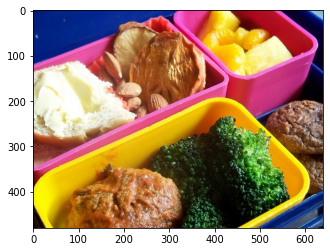

In [4]:
img = cv2.imread(img_path)
print("Dims: ", img.shape)
plt.imshow(img[:,:,::-1])
plt.show()

0 255 112.1728121439616
Dims:  (512, 512, 3)


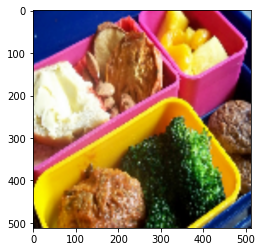

In [5]:
img = tf.io.read_file(img_path)
img = tf.io.decode_jpeg(img)
img = tf.image.resize(img, [128, 128], preserve_aspect_ratio=False)
img = tf.image.resize(img, [512, 512], preserve_aspect_ratio=False)
img = tf.cast(img, dtype=tf.uint8)
print(np.min(img), np.max(img), np.mean(img))
print("Dims: ", img.shape)
plt.imshow(img)
plt.show()

In [6]:
class DataLoader:
    def __init__(self, data_dir, input_shape=(128, 128), target_shape=(512, 512)):
        self.files = self.load_files(data_dir)
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.input_shape = input_shape
        self.target_shape = target_shape
    
    def load_files(self, root_dir):
        if not root_dir.endswith("*"):
            root_dir = os.path.join(root_dir, "*")
        
        return tf.data.Dataset.list_files(root_dir, shuffle=True)
    
    def process_image(self, image_path):
        img = tf.io.read_file(image_path)
        img = tf.io.decode_jpeg(img)
    
        input_image = tf.image.resize(
            img, 
            self.input_shape, 
        )
        input_image = tf.image.resize(
            input_image, 
            self.target_shape, 
        ) / 255
        
        target_image = tf.image.resize(
            img, 
            self.target_shape, 
        ) / 255.
        
        return input_image, target_image
    
    def data_generator(self, batch_size=64):
        dataset = self.files.map(self.process_image)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size = self.AUTOTUNE)
        return dataset
    
test_dataset = DataLoader(train_dir)
batch = test_dataset.data_generator(10)
inputs, targets = next(iter(batch))
print(f"Input Shape: {inputs.shape}, Target Shape: {targets.shape}")

Input Shape: (10, 512, 512, 3), Target Shape: (10, 512, 512, 3)


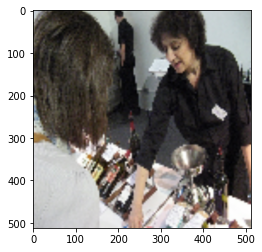

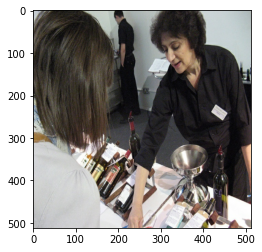

In [7]:
index = 1
plt.imshow(inputs[index], cmap="gray")
plt.show()
plt.imshow(targets[index], cmap="gray")
plt.show()

In [8]:
# Callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    "weights.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=4,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=10e-8,
)

# Model Architecture

input_img = tf.keras.Input(shape=(None, None, 3))
    
#encoding architecture
x1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
x3 = tf.keras.layers.MaxPool2D(padding='same')(x2)
x4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x4)
x6 = tf.keras.layers.MaxPool2D(padding='same')(x5)
encoded = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x6)

# decoding architecture
x7 = tf.keras.layers.UpSampling2D()(encoded)
x8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x7)
x9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x8)
x10 = tf.keras.layers.Add()([x5, x9])
x11 = tf.keras.layers.UpSampling2D()(x10)
x12 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x11)
x13 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x12)
x14 = tf.keras.layers.Add()([x2, x13])
decoded = tf.keras.layers.Conv2D(3, (3, 3), padding='same',activation='relu')(x14)
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.summary()

# Hyper Params
batch_size = 16
epochs = 500
lr = 0.001
input_shape=(80, 80)
target_shape=(224, 224)

opt = tf.keras.optimizers.Adam(learning_rate=lr)

autoencoder.compile(
    loss="binary_crossentropy", 
    optimizer=opt, 
    metrics=[
        "mse",
])

# Dataset Generator
train_dataset = DataLoader(train_dir, input_shape=input_shape, target_shape=target_shape)
train_generator = train_dataset.data_generator(batch_size)

val_dataset = DataLoader(val_dir, input_shape=input_shape, target_shape=target_shape)
val_generator = train_dataset.data_generator(batch_size)

# Calculate Num Steps
train_steps = len(list(train_dataset.files)) // batch_size + 1
val_steps = len(list(val_dataset.files)) // batch_size + 1


# Train
history = autoencoder.fit(
    train_generator,
    validation_data=val_generator,
    batch_size=batch_size, 
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

KeyboardInterrupt: 

In [ ]:
# Matplotlib Plots (For Easy Rendering)

# Learning Rate
plt.plot(history.history['lr'])
plt.title('Learning Rate')
plt.xlabel("Epochs")
plt.ylabel("LR Value")
plt.show()

# Loss Curves
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title('Loss Curves')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# MSE Curves
plt.plot(history.history['mse'], label="Train MSE")
plt.plot(history.history['val_mse'], label="Val MSE")
plt.title('MSE Curves')
plt.xlabel("Epochs")
plt.ylabel("MSe")
plt.legend()
plt.show()

In [12]:
inputs, targets = next(iter(val_generator))
preds = autoencoder.predict(inputs)

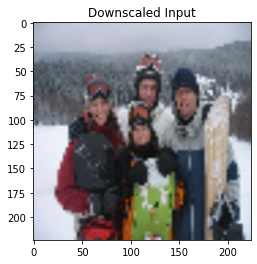

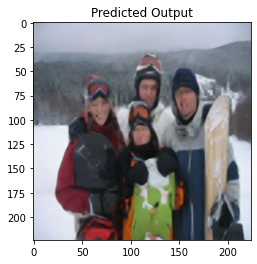

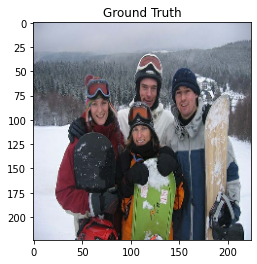

In [24]:
index = 7
plt.imshow(inputs[index], cmap="gray")
plt.title("Downscaled Input")
plt.show()
plt.imshow(preds[index] / tf.math.reduce_max(preds[index]), cmap="gray")
plt.title("Predicted Output")
plt.show()
plt.imshow(targets[index], cmap="gray")
plt.title("Ground Truth")
plt.show()